In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [105]:
df = pd.read_csv('creditcard.csv')

In [106]:
# Check for missing values
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [107]:
# Check class imbalance
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [108]:
# Scale 'Amount' and 'Time' features
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [109]:
# Handle imbalance using undersampling (optional)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0].sample(n=len(fraud))
df_balanced = pd.concat([fraud, non_fraud])

In [110]:
# Shuffle dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

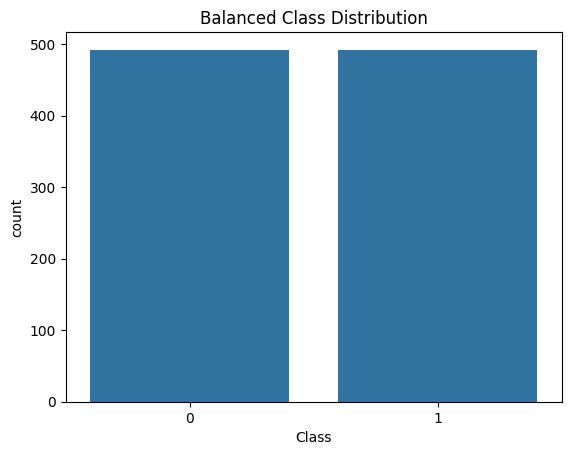

In [111]:
# Step 2: Exploratory Data Analysis (EDA)

# Plot class distribution
sns.countplot(x='Class', data=df_balanced)
plt.title("Balanced Class Distribution")
plt.show()

<ipython-input-112-885657ecfc30>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


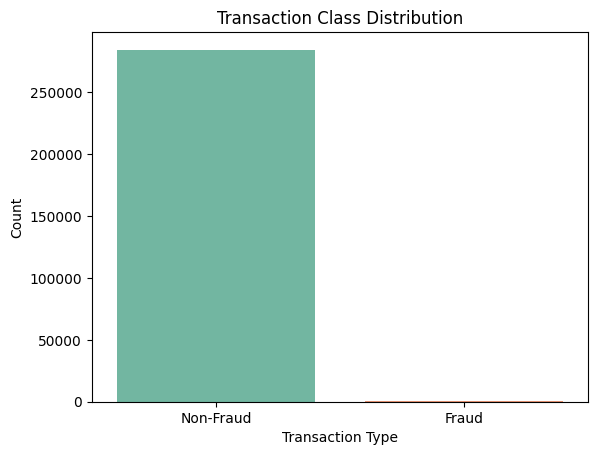

In [112]:
#Shows class imbalance between fraud and non-fraud.
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Transaction Class Distribution')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

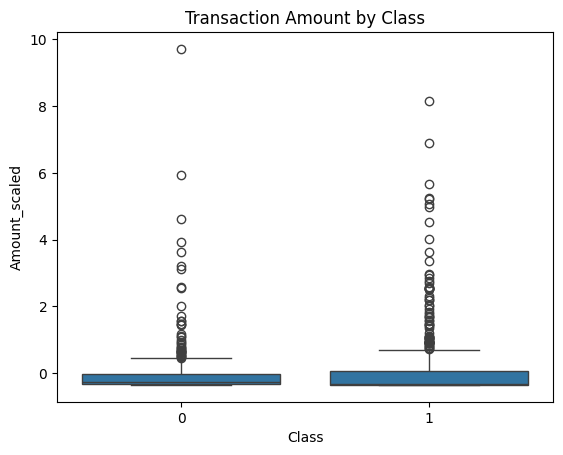

In [113]:
# Compare transaction amounts
sns.boxplot(x='Class', y='Amount_scaled', data=df_balanced)
plt.title("Transaction Amount by Class")
plt.show()

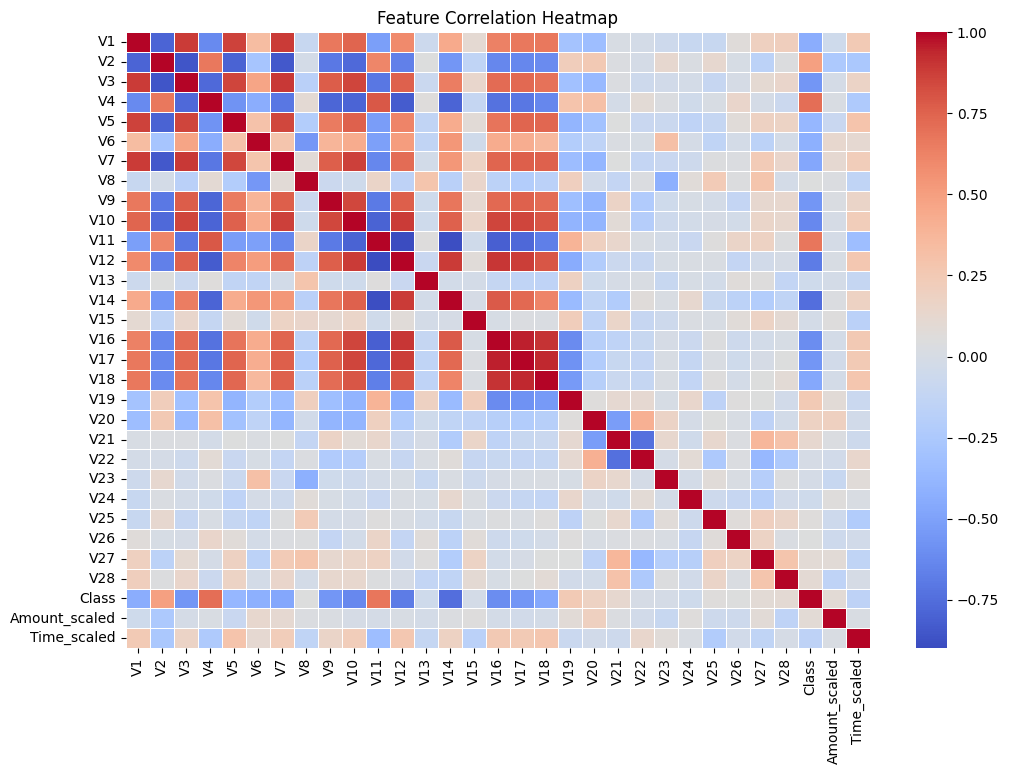

In [114]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_balanced.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

<ipython-input-115-a4bf83de49b9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df_balanced, palette='muted', split=True)


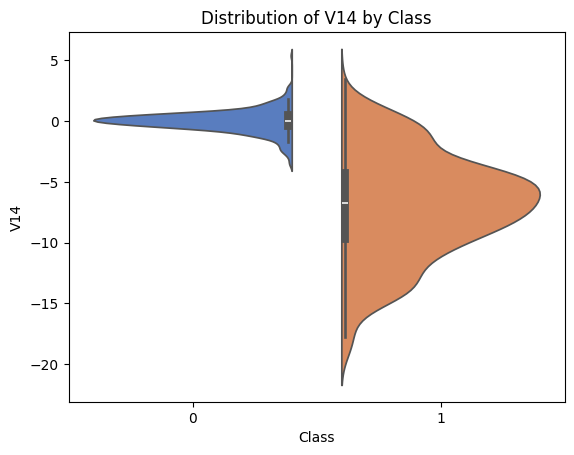

In [115]:
#Show how feature distributions differ between classes.
feature = 'V14'  # You can try V10, V12, V17 etc.

sns.violinplot(x='Class', y=feature, data=df_balanced, palette='muted', split=True)
plt.title(f"Distribution of {feature} by Class")
plt.show()


In [116]:
# Step 3: Feature Engineering

# Example: rolling stats (very basic idea)
df_balanced['rolling_mean_amt'] = df_balanced['Amount_scaled'].rolling(window=5).mean().fillna(0)

In [117]:
# Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
rfe_model = LogisticRegression()
selector = RFE(rfe_model, n_features_to_select=15)
selector = selector.fit(df_balanced.drop('Class', axis=1), df_balanced['Class'])

In [118]:
# Select top features
selected_features = df_balanced.drop('Class', axis=1).columns[selector.support_]
X = df_balanced[selected_features]
y = df_balanced['Class']

In [119]:
# Step 4: Model Building

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Model: Logistic Regression
[[105   0]
 [  7  85]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       105
           1       1.00      0.92      0.96        92

    accuracy                           0.96       197
   macro avg       0.97      0.96      0.96       197
weighted avg       0.97      0.96      0.96       197

AUC-ROC: 0.9955486542443064

Model: Random Forest
[[104   1]
 [ 10  82]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       105
           1       0.99      0.89      0.94        92

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197

AUC-ROC: 0.9914596273291926

Model: KNN
[[103   2]
 [  9  83]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       105
           1       0.98      0.90      0.94       

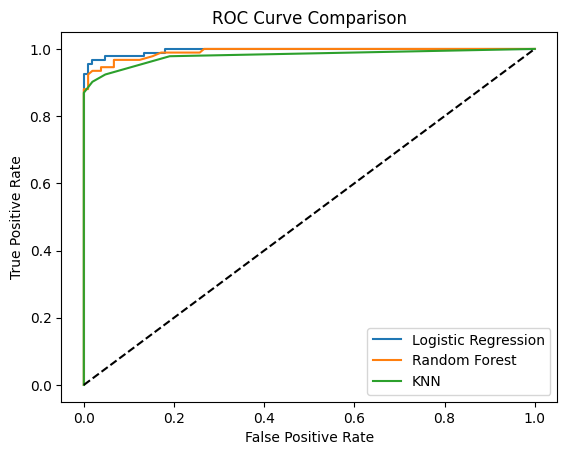

In [120]:
# Step 5: Visualization - AUC ROC Curve

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

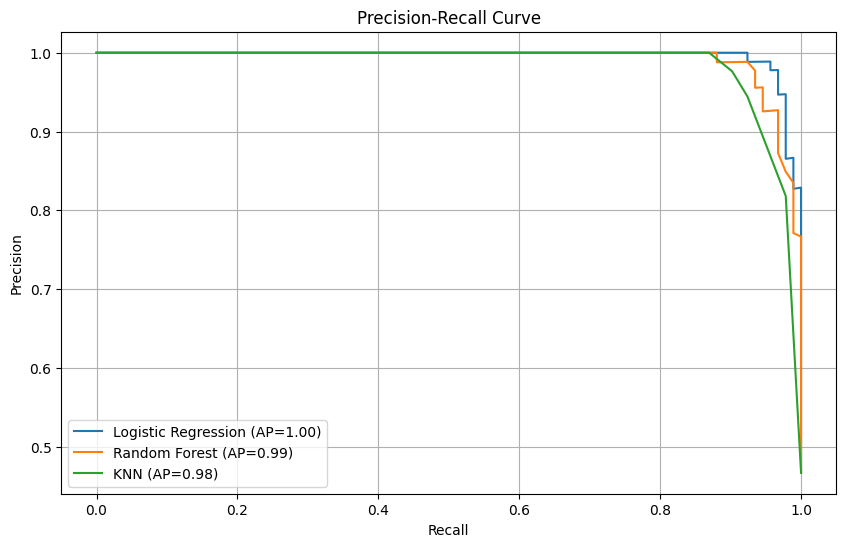

In [121]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)

    plt.plot(recall, precision, label=f"{name} (AP={ap_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [122]:
from sklearn.metrics import accuracy_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {acc:.4f}")

Accuracy for Logistic Regression: 0.9645
Accuracy for Random Forest: 0.9442
Accuracy for KNN: 0.9442
